# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Process, Queue, Pool
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import seaborn as sns
import math

In [ ]:
RANDOM_STATE = 99

# Util Func

In [ ]:
def binning(df, column, bin_edges, labels=None):
    """
    Function that performs binning for a numeric column in a Pandas dataframe.
    df: Pandas dataframe
    column: name of the numeric column to be binned
    bin_edges: list of bin edges to use
    labels: list of labels to assign to the bins
    """
    # Use the Pandas cut function to bin the column
    df[column + '_binned'] = pd.cut(df[column], bins=bin_edges, labels=labels)

    return df

In [ ]:
def cal_prob(df, freq_col):
    probability = []

    total = df[freq_col].sum()
    for i in df[freq_col]:
        probability.append(i/total)
    df['probability'] = probability

    return df

In [ ]:
def compare_attributes(df1, df2, columns_to_plot=None, legend_labels=None, title=None):
    if columns_to_plot is None:
        columns_to_plot = df1.columns

    # Iterate over each column in the dataframes
    for i, col in enumerate(columns_to_plot):
        # Create a new figure and axis object for each attribute
        fig, ax = plt.subplots()

        # Get the frequencies for each unique value in the column
        freq1 = df1[col].value_counts()
        freq2 = df2[col].value_counts()

        # Combine the frequencies into a single dataframe
        freq_df = pd.concat([freq1, freq2], axis=1, keys=['real', 'syn'])

        # Plot the frequencies as a bar chart
        freq_df.plot(kind='bar', ax=ax, rot=0)

        # Set the title for the subplot
        ax.set_title(title)
        ax.set_ylabel('Population')

        ax.set(xlabel=col)
        # ax.tick_params('x', labelrotation=45)
        # ax.set_xticks()
        # ax.set_xticklabels(rotation=45)

        # Add a legend to the plot
        plt.legend(legend_labels)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


        # Show the plot
        plt.show()


In [ ]:
def compare_cond_attributes(df1, df2, columns_to_plot=None, legend_labels=None, title=None):
    if columns_to_plot is None:
        columns_to_plot = df1.columns

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Iterate over each subplot
    for i, ax in enumerate(axs.flat):
        if i < len(columns_to_plot):
            # Get the column to plot
            col = columns_to_plot[i]

            # Get the frequencies for each unique value in the column
            freq1 = df1[col].value_counts()
            freq2 = df2[col].value_counts()

            # Combine the frequencies into a single dataframe
            freq_df = pd.concat([freq1, freq2], axis=1, keys=['df1', 'df2'])

            # Plot the frequencies as a bar chart
            freq_df.plot(kind='bar', ax=ax, rot=0)

            # Set the title for the subplot
            ax.set_title(title)

            ax.set(xlabel=col)
            ax.tick_params('x', labelrotation=45)
            # ax.set_xticks()
            # ax.set_xticklabels(rotation=45)

            # Add a legend to the plot
            ax.legend(legend_labels)

    # Show the plot
    plt.show()


In [ ]:
def plot_attribute_distribution(df):
    # check the distribution of each attribute
    # iterate over columns in dataframe
    for col in df.columns:
        # count the frequency of each attribute
        value_counts = df[col].value_counts()
        # create a bar chart of the frequency of each attribute
        plt.figure()
        plt.bar(value_counts.index, value_counts.values)
        plt.title(col)
        plt.show()

In [ ]:
def print_uniq_val(df):
    # Create an empty dictionary to store unique values for each column
    unique_values_dict = {}

    # Iterate through each column of the dataframe
    for column_name in df.columns:
        # Get the unique values of the current column
        unique_values = df[column_name].unique().tolist()

        # Sort the unique values
        unique_values.sort()

        # Store the sorted unique values in the dictionary
        unique_values_dict[column_name] = unique_values

    # Print the unique values for each column
    for column_name, unique_values in unique_values_dict.items():
        print(f"Column name: {column_name}")
        print(f"Unique values: {unique_values}")
        print(f"Total unique values: {len(unique_values)}")
        print("\n")

# Import Synthetic and Test Datasets

## Transformer Population

In [ ]:
transformer = pd.read_csv('results/tfm.csv')

In [ ]:
transformer.head()

,sex,age,marst,classwk
0,202,24,301,400
1,202,36,309,401
2,201,43,302,401
3,202,44,302,402
4,202,8,301,400


In [ ]:
transformer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sex      992 non-null    int64
 1   age      992 non-null    int64
 2   marst    992 non-null    int64
 3   classwk  992 non-null    int64
dtypes: int64(4)
memory usage: 31.1 KB


## Test Set

In [ ]:
test_set = pd.read_csv('data/test_df.csv')

In [ ]:
test_set.head()

,sex,age,marst,classwk
0,201,40,302,401
1,201,43,302,401
2,202,50,302,403
3,202,50,302,402
4,202,43,303,401


In [ ]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60451 entries, 0 to 60450
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sex      60451 non-null  int64
 1   age      60451 non-null  int64
 2   marst    60451 non-null  int64
 3   classwk  60451 non-null  int64
dtypes: int64(4)
memory usage: 1.8 MB


## Train Set

In [ ]:
train_set = pd.read_csv('data/train_df.csv')

In [ ]:
train_set.head()

,sex,age,marst,classwk
0,201,56,302,401
1,202,17,301,400
2,202,6,301,400
3,202,79,304,400
4,201,20,301,400


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435254 entries, 0 to 435253
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   sex      435254 non-null  int64
 1   age      435254 non-null  int64
 2   marst    435254 non-null  int64
 3   classwk  435254 non-null  int64
dtypes: int64(4)
memory usage: 13.3 MB


# Restore values of categorical attributes


In [ ]:
df_lists = [transformer, train_set, test_set]

for df in df_lists:
    df['sex'] = df['sex'] - 200
    df['marst'] = df['marst'] - 300
    df['classwk'] = df['classwk'] - 400

In [ ]:
for i in df_lists:
    i.info()
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sex      992 non-null    int64
 1   age      992 non-null    int64
 2   marst    992 non-null    int64
 3   classwk  992 non-null    int64
dtypes: int64(4)
memory usage: 31.1 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435254 entries, 0 to 435253
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   sex      435254 non-null  int64
 1   age      435254 non-null  int64
 2   marst    435254 non-null  int64
 3   classwk  435254 non-null  int64
dtypes: int64(4)
memory usage: 13.3 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60451 entries, 0 to 60450
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sex      60451 non-null  int64
 1   age      60451 non-null  int64
 2   marst    

# Distributional similarity (SRMSE)

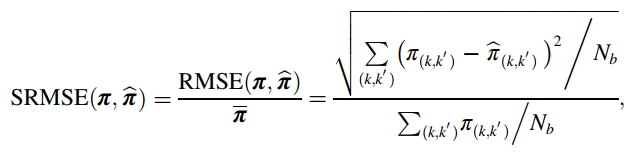

In [ ]:
def sum_list(nums):
  """
  This function takes a list of numbers as input and returns the sum of the numbers.

  Args:
    nums: A list of numbers.

  Returns:
    The sum of the numbers in the list.
  """

  total = 0  # Initialize a variable to store the sum
  for num in nums:  # Iterate through each number in the list
    total += num  # Add the current number to the total
  return total  # Return the final sum


def multiply_list(nums):
  """
  This function takes a list of numbers as input and returns the product of the numbers.

  Args:
    nums: A list of numbers.

  Returns:
    The product of the numbers in the list.
  """

  product = 1  # Initialize a variable to store the product
  for num in nums:  # Iterate through each number in the list
    product *= num  # Multiply the current number to the product
  return product  # Return the final product


def srmse(real, syn, columns=None):
    if columns is None:
        columns = real.columns

    # category_comb = []
    rmse = []
    pie = []

    # Iterate over each column in the dataframes
    for col in columns:
        # Get the frequencies for each unique value in the column
        freq_r = real[col].value_counts()
        freq_s = syn[col].value_counts()

        # Combine the frequencies into a single dataframe
        freq_df = pd.concat([freq_r, freq_s], axis=1, keys=['real', 'syn'])

        freq_df['err'] = pow((freq_df['real'] - freq_df['syn']), 2)
        freq_df['real'].fillna(0, inplace=True)
        freq_df['syn'].fillna(0, inplace=True)
        freq_df['err'].fillna(0, inplace=True)

        rmse.extend(list(freq_df['err']))
        pie.extend(list(freq_df['real']))


    x = sum_list(rmse)
    y = sum_list(pie)

    res = math.sqrt(x)/y

    return res


In [ ]:
# transformer_srmse = srmse(real=test_set, syn=transformer.sample(n=len(test_set), random_state=RANDOM_STATE))
transformer_srmse = srmse(real=test_set.sample(n=len(transformer), random_state=RANDOM_STATE), syn=transformer)
print(f"Transformer's SRMSE based on test set: {transformer_srmse:.4f}")

Transformer's SRMSE based on test set: 0.0258


# Diversity

Find nearest using KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors=1)

In [ ]:
neigh.fit(train_set)

NearestNeighbors(n_neighbors=1)

In [ ]:
pred_syn = neigh.kneighbors(transformer, return_distance=True)

# calculate the mean and standard deviation of the array
mean = np.mean(pred_syn[0])
std_dev = np.std(pred_syn[0])

# print the results
print("Transformer Mean:", mean)
print("Transformer Standard deviation:", std_dev)

Transformer Mean: 0.009072580645161291
Transformer Standard deviation: 0.12263219814703041
